In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

## Data


### ES

In [ ]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0,a_domain, b_domain, lengths,A,B, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00
    

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = a_domain + (np.random.rand(population_size, chromosome_length)) * (b_domain-a_domain) #CHANGE
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions, lengths, A, B)
    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)
        
        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)
        
        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        temp_population_solution = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)
        term=0
        while term<10 and (np.any(temp_population_solution<a_domain) or np.any(temp_population_solution>b_domain)): #CHANGE
          temp_population_solution = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)
          term+=1
        if term < 10:
          children_population_solutions = temp_population_solution
        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions, lengths, A, B)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        #if np.mod(t, log_frequency) == 0:
            #print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

### Draw Function

In [ ]:
def draw(alpha, length, A, B):
    plt.figure()
    tempPoint = A
    plt.scatter(A[0], A[1], c='black', s=100)
    plt.scatter(B[0], B[1], c='red', s=100)
    tempAlpha = 0
    for i in range(len(alpha)):
        tempAlpha += alpha[i]
        A = tempPoint + np.array([length[i]*np.cos(tempAlpha), length[i]*np.sin(tempAlpha)])
        x_values = [tempPoint[0], A[0]]
        y_values = [tempPoint[1], A[1]]
        plt.plot(x_values, y_values, linestyle="-")
        tempPoint = A
        plt.scatter(A[0], A[1], c='black', s=25)
    plt.axis('equal')
    plt.show()

### Objectvie Function

In [ ]:
def inverse_kinematic(alpha, length,A,B):
  alpha2=(2*alpha*np.pi)/360
  res=np.zeros((2,len(alpha[:,0])))
  temp = np.zeros(len(alpha[:,0]))
  for i in range(len(length)):
    temp+=alpha2[:, i]
    res+=np.array([length[i]*np.cos(temp), length[i]*np.sin(temp)])
  return -np.sqrt((res[0, :] - B[0])**2 + (res[1, :] - B[1])**2)

## Inverse Kinematic Problem

### Simple test

In [ ]:
a_domain = np.array([-90,-90,-90,-90,-90])
b_domain = np.array([90,90,90,90,90])
lengths = np.array([2,2,2,2,2])
A=np.array([0.0,0.0])
B=np.array([8.0,2.0])
d = len(a_domain)
N = 2000
T = 100
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematic, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),a_domain, b_domain, lengths,A,B, 10)

[ 38.6467966    2.38087655 -26.94016178   4.2675228  -75.43901169]
[-0.00430027]


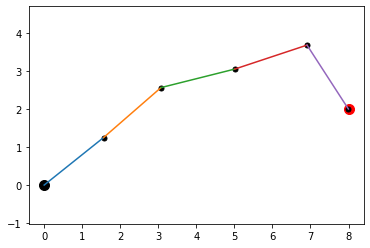

In [ ]:
print(history_best_chromosome[d-1])
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)

### A=B

In [ ]:
a_domain = np.array([-90,-90,-90,-90,-90])
b_domain = np.array([90,90,90,90,90])
lengths = np.array([2,2,2,2,2])
A=np.array([0.0,0.0])
B=np.array([0.0,0.0])
d = len(a_domain)
N = 2000
T = 100
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematic, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),a_domain, b_domain, lengths,A,B, 10)

[-25.50905785 -52.93769177 -82.29250427 -71.49198508 -64.77544712]
[-0.11763829]


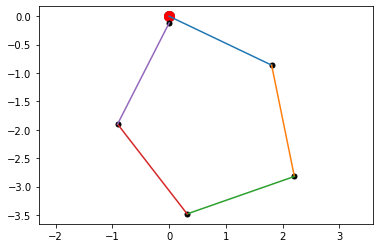

In [ ]:
print(history_best_chromosome[d-1])
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)

### Hexagon

In [ ]:
a_domain = np.array([45,45,45,45,45,45])
b_domain = np.array([75,75,75,75,75,75])
lengths = np.array([2,2,2,2,2,2])
A=np.array([0.0,0.0])
B=np.array([0.0,0.0])
d = len(a_domain)
N = 2000
T = 100
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematic, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),a_domain, b_domain, lengths,A,B, 10)

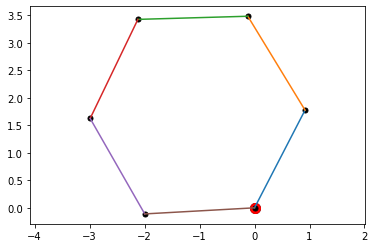

[62.6570366  58.70455046 60.27218426 62.64399035 55.47500894 63.42438656]
[-6.35293307e-06]


In [ ]:
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)
print(history_best_chromosome[d-1])
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))

### Small angle

In [ ]:
a_domain = np.random.rand(25)-25
b_domain = np.random.rand(25)+25
lengths = 10*np.random.rand(25)
A=np.array([0.0,0.0])
B=np.array([20.0,40.0])
d = len(a_domain)
N = 2000
T = 100
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematic, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),a_domain, b_domain, lengths,A,B, 10)

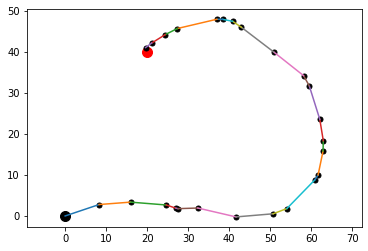

[ 18.59469212 -14.23242599  -8.93008273 -13.8335313    6.24363362
  13.95517749 -14.8723212   17.91842398  15.98670341  24.90337522
  11.35967146  21.18199425  10.47462828  10.56520003   8.13264873
  12.00406485  22.14901918   1.01912009   3.03680595  23.32487676
  10.06284468  14.15896398  13.57512992   5.08408755   4.87580648]
[-1.12437379]


In [ ]:
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)
print(history_best_chromosome[d-1])
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))

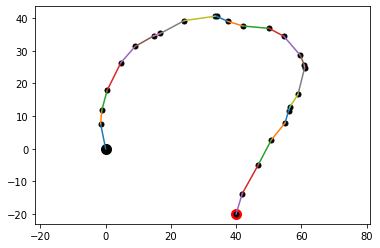

[-11.43405746  16.49854975  10.03518562  11.21006337  14.87542904
  19.26119971   9.46734103  -8.12483157  20.20996894  14.64271581
  17.90708649  -7.78388409 -11.548753    22.78395967  21.16198359
  19.2453763   15.23318268  20.43671783  18.78182142 -13.04154409
  -4.02515701  22.76457002 -10.88407014   1.41472132 -12.24421183]
[-1.57289715e-05]


In [ ]:
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)
print(history_best_chromosome[d-1])
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))

### 90 degrees

In [ ]:
a_domain = np.random.rand(25)+80
b_domain = np.random.rand(25)+90
lengths = 10*np.random.rand(25)
A=np.array([0.0,0.0])
B=np.array([1.0,-2.0])
d = len(a_domain)
N = 2000
T = 100
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematic, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),a_domain, b_domain, lengths,A,B, 10)

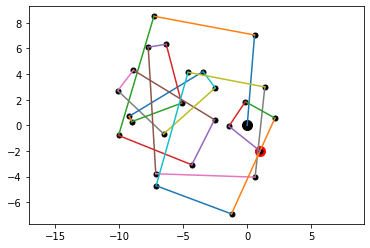

[85.34754145 84.1048132  84.03411215 84.65765725 85.11382515 85.29355504
 84.11982884 84.01647795 85.07292428 84.82729597 84.62717078 84.63063666
 84.54624328 84.25811293 84.48000675 84.29284648 84.61930455 85.77526956
 85.37185947 85.10983681 85.21277672 86.12562513 85.2845727  85.39515809
 85.07500153]
[-2.6955922e-10]


In [ ]:
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)
print(history_best_chromosome[d-1])
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))

### Lots of points

In [ ]:
a_domain = np.random.rand(50)-90
b_domain = np.random.rand(50)+90
lengths = 2*np.ones(50)
A=np.array([0.0,0.0])
B=np.array([15.0,15.0])
d = len(a_domain)
N = 2000
T = 100
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematic, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),a_domain, b_domain, lengths,A,B, 10)

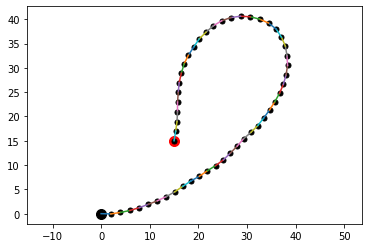

[-1.48495492 10.19243332  3.02949439  5.20078957  2.92697786  1.9892777
  2.9645592   4.5618209   5.29290205 -1.47040951 -3.87560121  5.01769984
 -2.25634025  4.38955449  7.68049346  1.66181724  2.9252107  -7.71865286
  3.89377726  6.84573019  2.38450695  3.10736777  3.66933782  5.90779668
  7.02278009  7.13035248 12.40443068  6.14558642 14.14207052  9.27571648
 18.72844949 14.59225508  9.51819717 11.22780464 10.54054575 11.95982915
 11.28594333 10.39258861  3.42412489 11.58354774  0.35767049  7.48607791
  9.19555844  3.89662282  7.63441656  0.93661581  4.01170094 -2.51388683
 -5.03206305 -1.91827106]
[-6.97513606e-13]


In [ ]:
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)
print(history_best_chromosome[d-1])
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))

### Spirals

In [ ]:
a_domain = np.random.rand(50)
b_domain = np.random.rand(50)+90
lengths = 2*np.ones(50)
A=np.array([0.0,0.0])
B=np.array([10.0,10.0])
d = len(a_domain)
N = 2000
T = 100
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematic, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),a_domain, b_domain, lengths,A,B, 10)

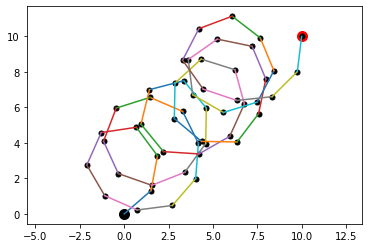

[40.94393676 38.49622533 47.18714444 61.9415341  57.47247348 54.26900838
 35.84337273 31.17194546 41.74696764 36.4519307  30.80486392 40.38132808
 40.79115846 51.56240561 45.47909018 46.07037515 40.92643242 32.36915907
 35.00375695 40.58358205 65.11328745 61.62291558 53.04983497 46.97050868
 33.4389308  35.95009457 39.59151959 57.27577917 59.99942494 46.36301166
 51.17845145 38.97170978 53.58778267 25.54269545 34.62669685 55.51717623
 46.79826959 61.95873126 52.95995208 47.08867149 45.07749212 50.42884837
 29.81574362 58.06226516 42.2286071  62.73043299 35.98431173 24.65078144
 38.69441842 38.22098753]
[-1.65582758e-13]


In [ ]:
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)
print(history_best_chromosome[d-1])
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))

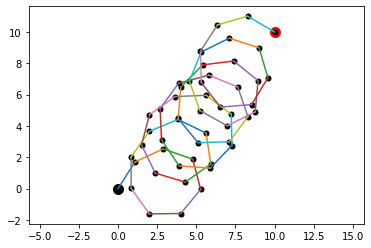

[-4.14314051e-14]


In [ ]:
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))

### Smaller spirals

In [ ]:
a_domain = np.random.rand(25)
b_domain = np.random.rand(25)+90
lengths = 5*np.ones(25)
A=np.array([0.0,0.0])
B=np.array([30.0,30.0])
d = len(a_domain)
N = 2000
T = 100
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematic, d, N, T, 3*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),a_domain, b_domain, lengths,A,B, 10)


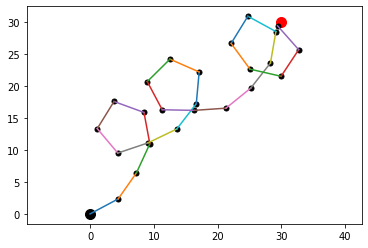

[28.04351615 26.9230937  10.30979551 35.30523093 59.32437965 78.39245622
 71.75820276 68.53764712  7.13280203 26.5851785  32.50203426 71.43161838
 68.45233729 73.28924166 60.93348788  5.02835259 35.04579613 12.8835713
 28.36245394 71.10381905 86.98758025 67.88211244 40.8493398  69.44282686
 75.00862837]
[-0.8038672]


In [ ]:
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)
print(history_best_chromosome[d-1])
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))

### Lots of points far away

In [ ]:
a_domain = np.random.rand(100)-90
b_domain = np.random.rand(100)+90
lengths = 5*np.ones(100)
A=np.array([0.0,0.0])
B=np.array([200.0,200.0])
d = len(a_domain)
N = 2000
T = 100
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematic, d, N, T, 3*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),a_domain, b_domain, lengths,A,B, 10)


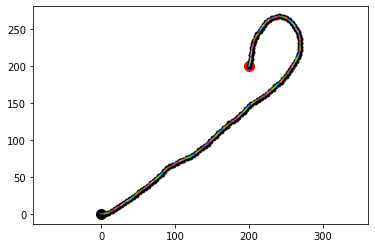

[  5.52576416   6.63256517  14.71096202   5.75970254  -0.82100586
  -1.16730316   6.27137316  -2.42425412  -5.35729207   8.60543804
   1.96023575   0.88140912  -3.02025431  -7.57392835   9.68641454
   2.84394202  -6.87792315   3.80485639   2.12179107   5.03799163
  -2.05782426  -1.56318155 -10.05066318  -4.72194463   2.61722359
  -1.7677756   -6.53918874  -0.54021052  -0.35313973   8.10818726
   9.36022899  -2.8082865    2.14501267   2.85120735  -4.40894744
   7.91265437   0.95426244  -4.80528022   6.18739824  -5.44963572
   0.78024485  -2.3517084   -0.82123857  -4.05569329   0.94416275
   3.79001018   2.78191718   1.18809459   2.45599978   2.58892264
  -7.5822098   -7.52754486  -0.75999012  -3.11116681   1.05128584
   8.88717103  -2.5272888    4.3159118    1.77775368  -2.25289711
  -2.12444044  10.93024994   0.91262437  -0.8503647    2.97839602
   5.86435473  -1.08610902   3.34799818   0.21652045   5.68740926
   9.19176239   9.13684817   6.33332845   1.04361135   5.08232491
  13.89682

In [ ]:
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)
print(history_best_chromosome[d-1])
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))

### Lots of points very close

In [ ]:
a_domain = np.random.rand(100)-90
b_domain = np.random.rand(100)+90
lengths = 5*np.ones(100)
A=np.array([0.0,0.0])
B=np.array([10.0,10.0])
d = len(a_domain)
N = 2000
T = 100
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematic, d, N, T, 3*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),a_domain, b_domain, lengths,A,B, 10)


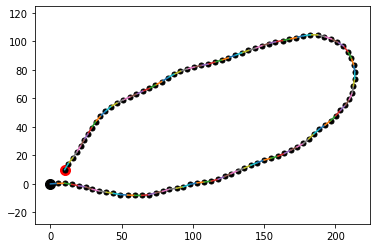

[ 3.92191767e+00 -2.79241922e+00 -9.94413485e+00 -2.22543653e+00
  1.44211962e+00 -1.03984376e+01  6.92606550e+00  2.71655559e+00
  1.05099231e+00  9.35549635e-03  4.97153670e+00  1.68806669e+00
  2.69680843e+00  5.29157885e+00  9.92433373e+00 -2.85146368e+00
  4.96232705e+00 -9.84332393e+00  4.85469331e+00  7.40856578e+00
 -7.64221963e+00 -5.68866671e+00  9.89126416e-01  7.10593968e+00
  8.58363692e+00  1.19609981e+00 -5.77891550e-01 -2.18751449e+00
  1.81432467e+00 -1.22359906e+00 -2.08866197e+00 -4.88747217e+00
  1.01566549e+00  7.17125676e+00  3.73395233e+00  6.62648915e-02
  1.74593751e+00  1.17518811e+01  3.52409186e+00 -3.21801554e+00
 -5.68196930e+00  3.16822497e+00  5.87014283e+00  4.11975133e+00
 -2.58803444e+00  1.02703866e+01  9.65528293e+00  1.53365989e+01
 -1.45309044e+00  9.27125524e+00  1.07570719e+01  9.30622181e+00
  9.38768694e+00  9.68561757e+00  1.89581844e+01  5.34110935e+00
  8.76850169e+00  5.57524276e+00  1.23388215e+01  9.05001336e+00
  6.40108292e+00 -1.48700

In [ ]:
draw(np.radians(history_best_chromosome[d-1]),lengths,A,B)
print(history_best_chromosome[d-1])
print(inverse_kinematic(np.reshape(history_best_chromosome[d-1], (1, d)), lengths, A, B))